In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from statsmodels.multivariate.manova import MANOVA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from pandas.plotting import parallel_coordinates
import scipy.stats as stats
import numpy as np

iris = fetch_ucirepo(id=53)

x = iris.data.features
y = iris.data.targets

In [2]:
iris_data_set = x.join(y)
iris_data = iris_data_set.loc[(iris_data_set['class'] == 'Iris-versicolor') | (iris_data_set['class'] == 'Iris-setosa')]
iris_data.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']

## переобозначим классы Iris-setosa и Iris-versicolor в 0 и 1 соответственно

In [3]:
class_mapping = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
}
iris_data = iris_data.loc[
    (iris_data_set['class'] == 'Iris-versicolor') | (iris_data_set['class'] == 'Iris-setosa')
    ].copy()

iris_data['class'] = iris_data['class'].map(class_mapping).astype('category')



In [4]:
iris_data = iris_data.rename(columns={'class': 'class_label'})

In [5]:
iris_data

,sepal_length,sepal_width,petal_length,petal_width,class_label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


In [6]:
for label in iris_data['class_label'].unique():
    print(f"\nКласс {label}:")
    x_filtered = iris_data[iris_data['class_label'] == label]
    for feature in x_filtered.columns[:-1]:
        stat, p = stats.kstest(x_filtered[feature], 'norm',
                               args=(x_filtered[feature].mean(), x_filtered[feature].std()))
        print(f"  {feature} - p-value: {p:.2f}")



Класс 0:
  sepal_length - p-value: 0.49
  sepal_width - p-value: 0.49
  petal_length - p-value: 0.15
  petal_width - p-value: 0.00

Класс 1:
  sepal_length - p-value: 0.71
  sepal_width - p-value: 0.43
  petal_length - p-value: 0.46
  petal_width - p-value: 0.20


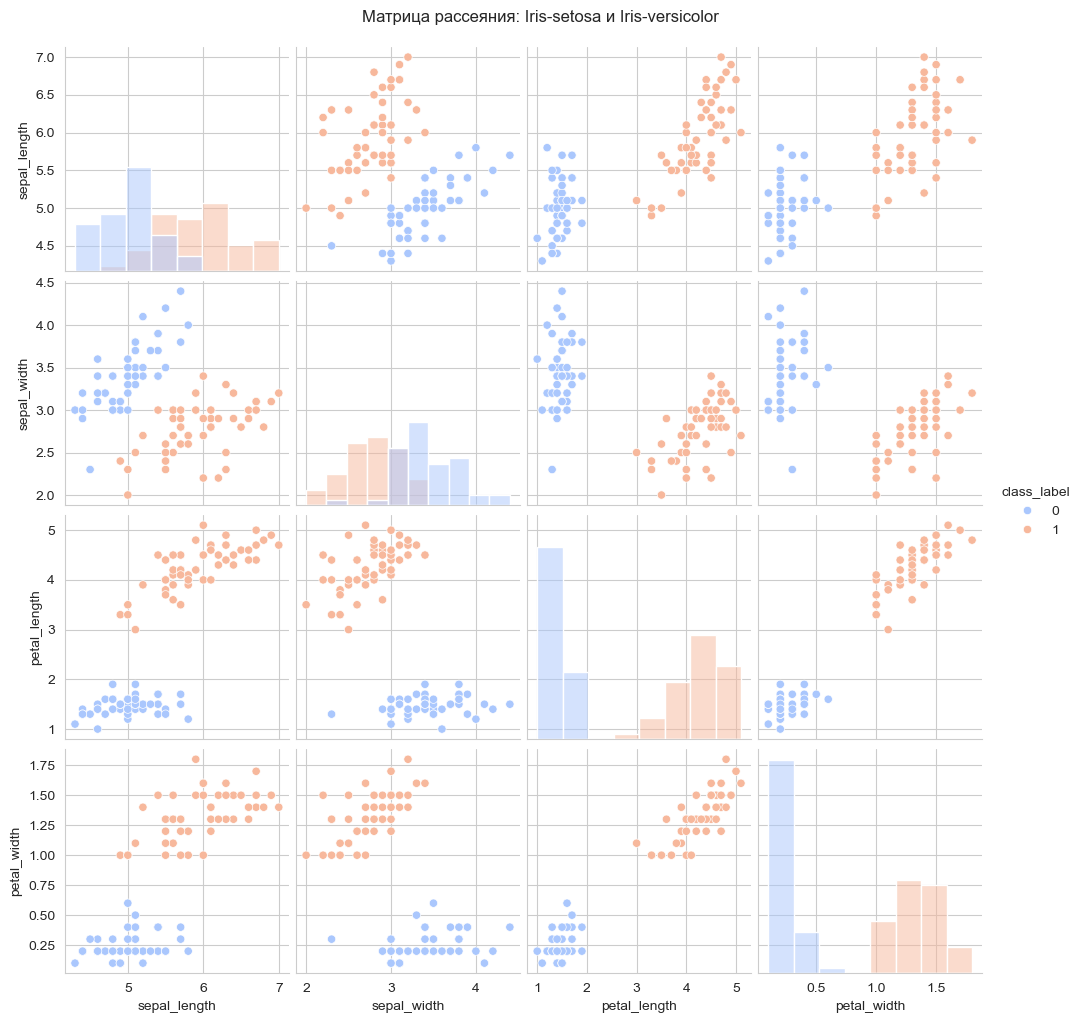

In [28]:
sns.pairplot(iris_data, hue='class_label', diag_kind='hist', palette='coolwarm')
plt.suptitle("Матрица рассеяния: Iris-setosa и Iris-versicolor", y=1.02)
plt.show()


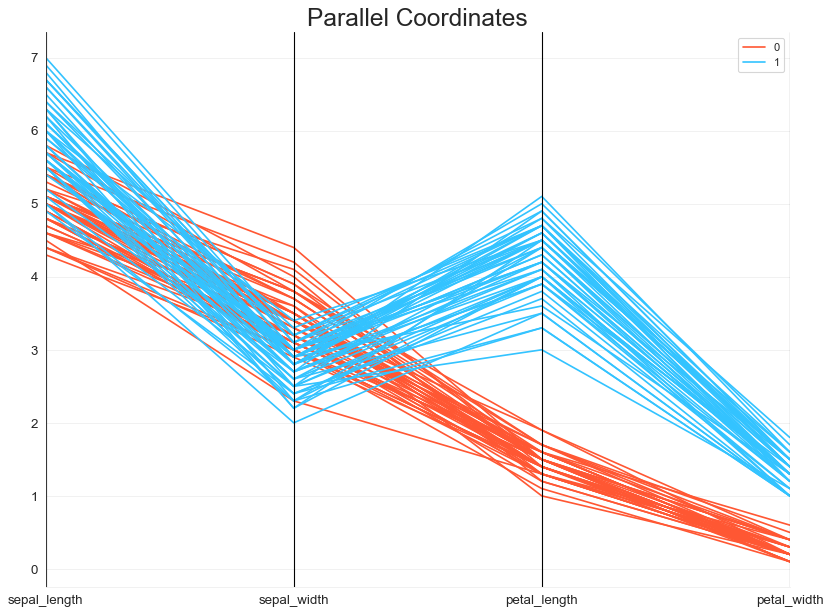

In [8]:
plt.figure(figsize=(12, 9), dpi=80)
parallel_coordinates(iris_data, 'class_label', color=['#FF5733', '#33C3FF'])  # Цвета для классов

plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(0.3)

plt.title('Parallel Coordinates', fontsize=22)
plt.grid(alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [10]:
x = iris_data.drop('class_label', axis=1)
y = iris_data['class_label']

In [11]:
manova = MANOVA.from_formula('sepal_length + sepal_width + petal_length + petal_width ~ class_label', data=iris_data)
print(manova.mv_test())

                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept         Value  Num DF  Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda  0.0112 4.0000 95.0000 2101.5108 0.0000
         Pillai's trace  0.9888 4.0000 95.0000 2101.5108 0.0000
 Hotelling-Lawley trace 88.4847 4.0000 95.0000 2101.5108 0.0000
    Roy's greatest root 88.4847 4.0000 95.0000 2101.5108 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
       class_label        Value  Num DF  Den DF F Value  Pr > F
---------------------------------------------------------------
           Wilks' lambda  0.0364 4.0000 95.0000 629.5632 0.0000
          Pillai's trace  0.9636 4.0000 95.0000 629.5632 0.

## ЛДА

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
lda = LinearDiscriminantAnalysis()

In [13]:
lda.fit(x_train, y_train)

LinearDiscriminantAnalysis()

In [14]:
y_pred_train = lda.predict(x_train)
y_pred_test = lda.predict(x_test)

In [15]:
coefficients = lda.coef_
intercepts = lda.intercept_

coefficients_df = pd.DataFrame(coefficients, columns=x.columns)
coefficients_df['Intercept'] = intercepts

print(coefficients_df)

   sepal_length  sepal_width  petal_length  petal_width  Intercept
0     -3.978414   -19.014159     22.809432    37.166645 -13.022473


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

        Predicted 0  Predicted 1
True 0           12            0
True 1            0            8


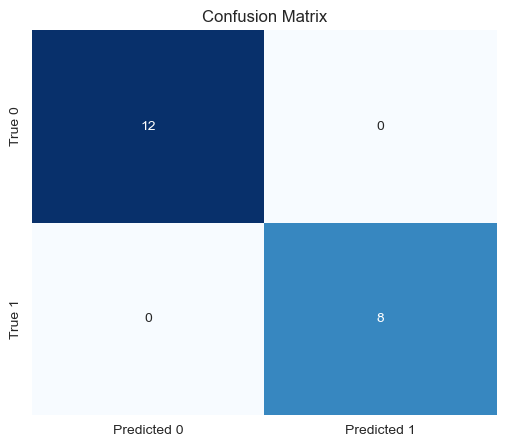

In [16]:
classification_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test
})

print(classification_report(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=[f"Predicted {i}" for i in range(len(set(y_test)))],
                              index=[f"True {i}" for i in range(len(set(y_test)))])
print(conf_matrix_df)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.show()


## дерево решений 


In [17]:
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
dt_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [18]:
y_pred = dt_model.predict(x_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[12  0]
 [ 0  8]]


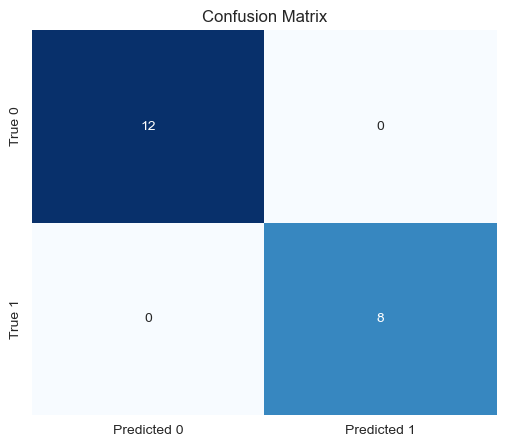

In [20]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.show()

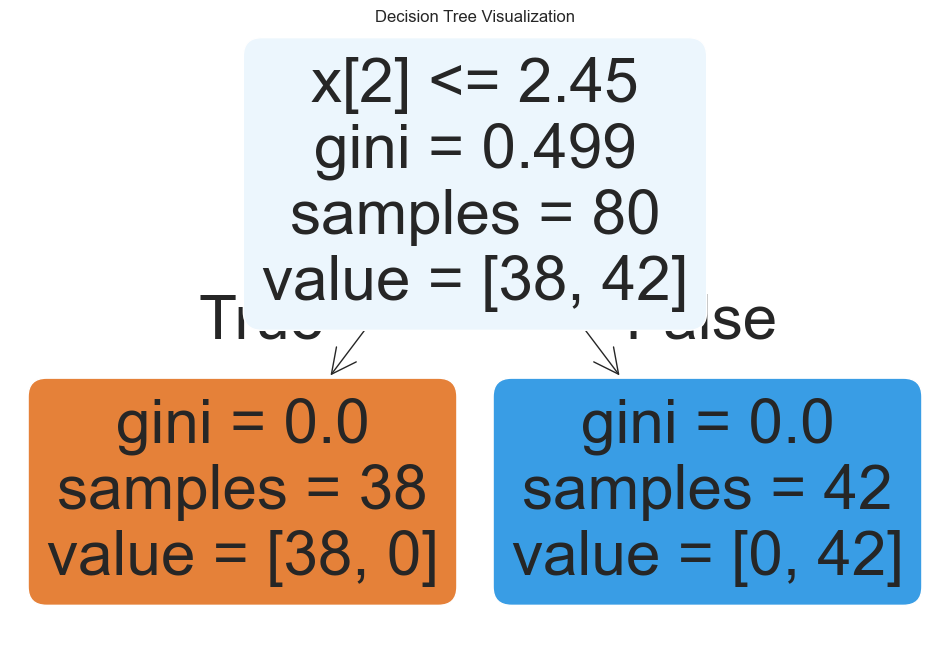

In [21]:
plt.figure(figsize=(12, 8))
plot_tree(dt_model, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()


## КДА

In [22]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(x_train, y_train)

QuadraticDiscriminantAnalysis()

In [23]:
y_pred = qda.predict(x_test)


In [24]:
accuracy = qda.score(x_test, y_test)
print(f"Точность на тестовой выборке: {accuracy:.2f}")

Точность на тестовой выборке: 1.00


In [25]:
print("\nОтчет о классификации:")
print(classification_report(y_test, y_pred))


Отчет о классификации:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [26]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix)


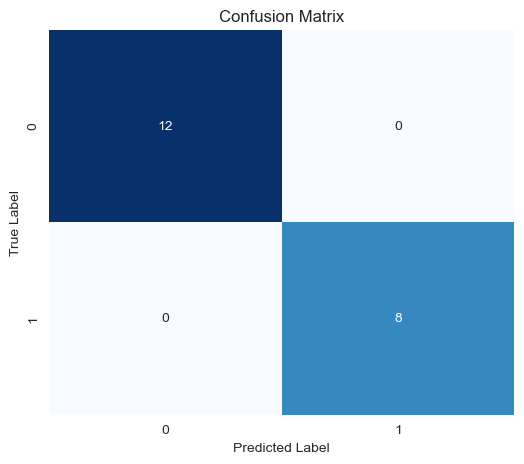

In [27]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_df, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()